In [1]:
import csv
import networkx as nx 
import numpy as np
import pandas as pd 
import igraph
from itertools import compress
import matplotlib.pyplot as plt 
import seaborn as sns
import copy
from seaborn import color_palette, set_style, palplot
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Load and clean data 

In [2]:
#import the aggregate adjacency matrix
def load_graph_from_adj(adj,country_name):
    '''
    load pre-prepared adj matrix, load country names form csv file as well 
    return networkx directed graph file
    '''
    aggregate_am = np.genfromtxt (adj, delimiter=",")
    df_names = pd.read_csv('../data/adj/all_country_name4.csv', header=None)
    names = list(df_names[0])
    #G = nx.from_numpy_matrix(np.transpose(aggregate_am),create_using=nx.DiGraph())
    G = nx.from_numpy_matrix(np.transpose(aggregate_am),create_using=nx.DiGraph())
    node_list = G.nodes()
    mapname = dict(zip(node_list,names))
    G = nx.relabel_nodes(G,mapname)
    
    return G

#### Create centrality measure time series 

In [3]:
def merge_degree(degree_centrality,G,var,year):
    # Find nodes with highest degree, unweighted 
    k=G.degree(weight=var)                                 ## get the degree centrality for all countries 
    k = pd.DataFrame(list(k.items()),columns=['country',year])      ## make it into dataframe
    k.sort_values(by=year,ascending=0,inplace=True)                 ## sort it 
    if degree_centrality is None:
        degree_centrality = k
    else:
        degree_centrality = pd.merge(degree_centrality,k,on='country',how='outer')
    return degree_centrality

def merge_between(between_centrality,G,var,year):
    ## betweeness 
    b = nx.betweenness_centrality(G,weight=var)  # weight='total_weight'
    between = pd.DataFrame(list(b.items()),columns=['country',year])      ## make it into dataframe
    between.sort_values(by=year,ascending=0,inplace=True)    
    if between_centrality is None:
        between_centrality = between
    else:
        between_centrality = pd.merge(between_centrality,between,on='country',how='outer')
    return between_centrality

def merge_eigenvector(eigenvector_centrality,G,var,year):
    ## eigenvector centrality
    e = nx.eigenvector_centrality_numpy(G,weight=var)
    eigenvector = pd.DataFrame(list(e.items()),columns=['country',year])      ## make it into dataframe
    eigenvector.sort_values(by=year,ascending=0,inplace=True)    
    if eigenvector_centrality is None:
        eigenvector_centrality = eigenvector
    else:
        eigenvector_centrality = pd.merge(eigenvector_centrality,eigenvector,on ='country',how='outer')
    return eigenvector_centrality

def merge_closeness(closeness_centrality,G,var,year):
    ## closeness centrality
    c=nx.closeness_centrality(G,distance =var )
    closeness = pd.DataFrame(list(c.items()),columns=['country',year])      ## make it into dataframe
    closeness.sort_values(by=year,ascending=0,inplace=True)   
    if closeness_centrality is None:
        closeness_centrality = closeness
    else:
        closeness_centrality = pd.merge(closeness_centrality,closeness,on ='country',how='outer')
    return closeness_centrality

def merge_local_cluster_coef(local_cluster,G,var,year):
    ## local cluster coefficient
    ud_G = to_undirected(G)
    lc=nx.clustering(G=ud_G,weight = 'weight')                           ## after changing to un_directed, weight name changed to weeight
    lc_df = pd.DataFrame(list(lc.items()),columns=['country',year])      ## make it into dataframe
    lc_df.sort_values(by=year,ascending=0,inplace=True)   
    if local_cluster is None:
        local_cluster = lc_df
    else:
        local_cluster = pd.merge(local_cluster,lc_df,on ='country',how='outer')
    return local_cluster

def merge_pagerank(pagerank_centrality,G,var,year):
    ## pagerank centrality
    p = nx.pagerank(G,weight=var)
    pagerank = pd.DataFrame(list(p.items()),columns=['country',year])      ## make it into dataframe
    pagerank.sort_values(by=year,ascending=0,inplace=True)    
    if pagerank_centrality is None:
        pagerank_centrality = pagerank
    else:
        pagerank_centrality = pd.merge(pagerank_centrality,pagerank,on ='country',how='outer')
    return pagerank_centrality

def to_undirected(G):
    node_list = G.nodes()
    node_list.sort()
    A = nx.to_numpy_matrix(G = G,nodelist=node_list,weight=var)
    ud_M = A + A.T 
    ud_G = nx.from_numpy_matrix(ud_M)
    ## relable node to country name 
    maplist = dict(zip(ud_G.nodes(), node_list))
    ud_G = nx.relabel_nodes(ud_G,maplist)
    return ud_G

def plot_top_n(centrality,n):
    top10 = centrality.ix[0:n]
    top10.index = top10.country
    top10.drop(labels='country',axis=1,inplace=True)
    top10.T.sort_index().plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def export_to_excel(name):
    writer = pd.ExcelWriter(name+'.xlsx', engine='xlsxwriter')
    #degree_centrality.to_excel(writer, sheet_name='degree')
    #between_centrality.to_excel(writer, sheet_name='between')
    #eigenvector_centrality.to_excel(writer, sheet_name='eigenvector')
    pagerank_centrality.to_excel(writer, sheet_name='pagerank')
    #closeness_centrality.to_excel(writer,sheet_name = 'closeness')
    #local_cluster.to_excel(writer,sheet_name = 'cluster')
    writer.save()

### General statistics 

In [4]:
var_weight = ['weight']
country_name = '../data/adj/all_country_name4.csv'

for var in var_weight:

    degree_centrality = None
    between_centrality = None
    eigenvector_centrality = None
    closeness_centrality = None
    local_cluster = None
    pagerank_centrality= None
    print(var)
    for year in range(2009,2016):
        adj = '../data/adj/AM4_all_nodes_aggregate' + str(year) +'.csv' 
        G = load_graph_from_adj(adj,country_name)
        #degree_centrality =  merge_degree(degree_centrality,G,var,year)
        #between_centrality = merge_between(between_centrality,G,var_dist,year)       ## not weighted 
        #eigenvector_centrality = merge_eigenvector(eigenvector_centrality,G,var,year)
        pagerank_centrality = merge_pagerank(pagerank_centrality,G,var,year)
        #closeness_centrality = merge_closeness(closeness_centrality,G,var_dist,year) ## use distance measure
        #local_cluster = merge_local_cluster_coef(local_cluster,G,var,year)
    ## exoprt to 
    export_to_excel('../result/excel/'+var)

weight


### Visualize

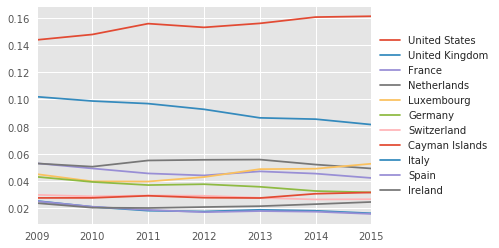

In [5]:
plot_top_n(pagerank_centrality,10)